# Qualitative Analysis - How consistent are their (Agentic-PRs) descriptions with the actual code changes?

In [15]:
!pip install sentence-transformers

In [16]:
from sentence_transformers import SentenceTransformer, util
import re

In [17]:
model = SentenceTransformer('all-MiniLM-L6-v2')

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns


In [19]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
df_pr_commit_details = pd.read_parquet('/content/drive/MyDrive/Research/AIDev/pr_commit_details.parquet')

df_pr_commit_details.head(3)

print('shape of pr_commit_details: ',df_pr_commit_details.shape)
print("Columns of pr_commit_details: ", list(df_pr_commit_details.columns))

shape of pr_commit_details:  (711923, 14)
Columns of pr_commit_details:  ['sha', 'pr_id', 'author', 'committer', 'message', 'commit_stats_total', 'commit_stats_additions', 'commit_stats_deletions', 'filename', 'status', 'additions', 'deletions', 'changes', 'patch']


In [21]:
merged_df = pd.read_parquet('/content/drive/MyDrive/Research/AIDev/merged_data.parquet')

merged_df.head()
print('Shape of merged_df:', merged_df.shape)

Shape of merged_df: (33580, 10)


In [22]:
def generate_code_summary(pr_id):
    """Generate a textual summary of code changes for a PR"""
    files_df = df_pr_commit_details[df_pr_commit_details['pr_id'] == pr_id]
    if files_df.empty:
        return ""

    summary_parts = []
    for _, row in files_df.iterrows():
        summary_parts.append(
            f"{row['status']} file {row['filename']} with {row['additions']} additions and {row['deletions']} deletions"
        )
    return ". ".join(summary_parts)

In [23]:
print(f"Generating code summaries for ALL {len(merged_df)} PRs...")
merged_df['code_summary'] = merged_df['pr_id'].apply(generate_code_summary)

Generating code summaries for ALL 33580 PRs...


In [24]:
with pd.option_context('display.max_colwidth', None):
    print(merged_df['code_summary'].head(2).to_string())


0    modified file .github/workflows/python-testing.yml with 12.0 additions and 0.0 deletions. modified file agentops/__init__.py with 35.0 additions and 0.0 deletions. modified file agentops/llms/providers/ai21.py with 15.0 additions and 61.0 deletions. modified file agentops/llms/providers/groq.py with 7.0 additions and 1.0 deletions. modified file agentops/llms/providers/litellm.py with 31.0 additions and 7.0 deletions. modified file agentops/llms/providers/mistral.py with 24.0 additions and 26.0 deletions. added file tests/ai21_handlers/test_ai21_integration.py with 82.0 additions and 0.0 deletions. added file tests/anthropic_handlers/test_anthropic_integration.py with 75.0 additions and 0.0 deletions. added file tests/cohere_handlers/test_cohere_integration.py with 83.0 additions and 0.0 deletions. added file tests/groq_handlers/test_groq_integration.py with 73.0 additions and 0.0 deletions. added file tests/litellm_handlers/test_litellm_integration.py with 73.0 additions and 0.0 

In [25]:
def calculate_similarity(desc, code_desc):
    if not desc or not code_desc:
        return np.nan
    desc_embedding = model.encode(desc)
    code_embedding = model.encode(code_desc)
    similarity = util.cos_sim(desc_embedding, code_embedding).item()
    return similarity

print("Calculating semantic similarity...")
merged_df['description_similarity'] = merged_df.apply(
    lambda row: calculate_similarity(row['full_description'], row['code_summary']), axis=1
)

Calculating semantic similarity...


In [26]:
similarity_df = merged_df.dropna(subset=['description_similarity'])

similarity_stats = similarity_df['description_similarity'].describe()
print("\nDescription-Code Similarity Statistics:")
print(similarity_stats)


Description-Code Similarity Statistics:
count    33580.000000
mean         0.413713
std          0.206465
min         -0.151170
25%          0.283714
50%          0.451679
75%          0.568847
max          0.884174
Name: description_similarity, dtype: float64


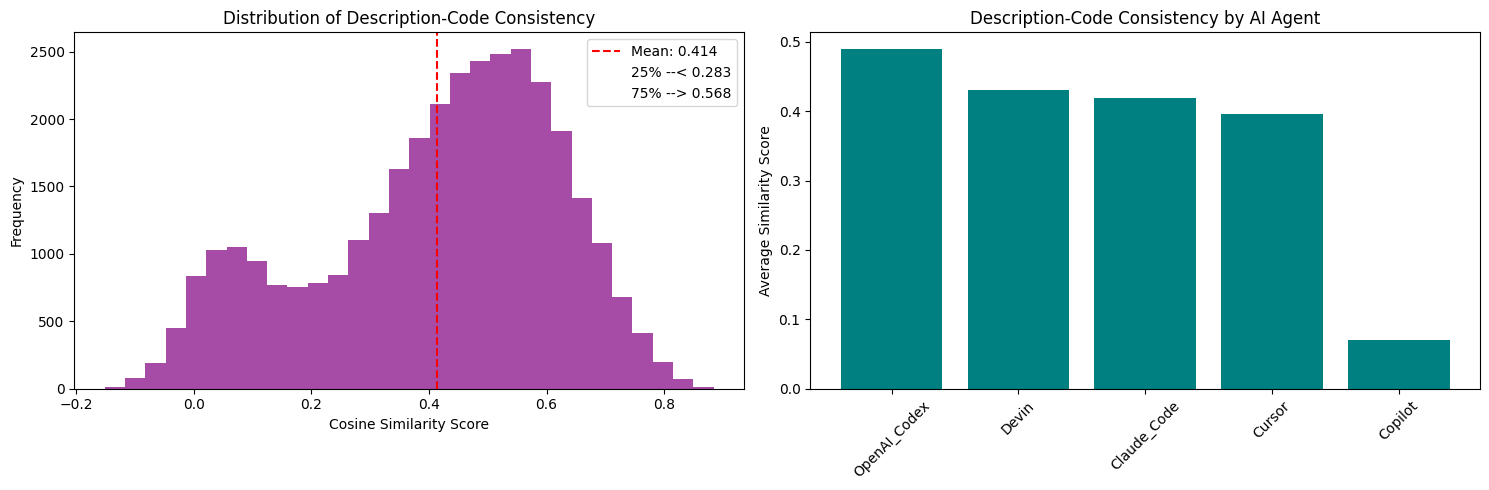

In [27]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].hist(similarity_df['description_similarity'], bins=30, alpha=0.7, color='purple')

axes[0].axvline(similarity_df['description_similarity'].mean(), color='red', linestyle='--',
                label=f'Mean: {similarity_df["description_similarity"].mean():.3f}')

axes[0].axvline(similarity_df['description_similarity'].mean(), color='red', linestyle='',
                label= '25% --< 0.283')

axes[0].axvline(similarity_df['description_similarity'].mean(), color='red', linestyle='',
                label= '75% --> 0.568')

axes[0].set_xlabel('Cosine Similarity Score')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Description-Code Consistency')
axes[0].legend()

agent_similarity = similarity_df.groupby('agent')['description_similarity'].mean().sort_values(ascending=False)
axes[1].bar(agent_similarity.index, agent_similarity.values, color='teal')
axes[1].set_ylabel('Average Similarity Score')
axes[1].set_title('Description-Code Consistency by AI Agent')
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.savefig('qualitative_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [35]:

print("ANOVA Test for Similarity Differences Between Agents:")
agent_groups = [group['description_similarity'].values for agent, group in similarity_df.groupby('agent')
               if len(group) > 50]
f_stat, p_value = stats.f_oneway(*agent_groups)
print(f"F-statistic: {f_stat:.3f}, p-value: {p_value:.3f}")

correlation_matrix = similarity_df[['total_additions', 'total_deletions', 'files_touched',
                                  'description_similarity']].corr()
print("\nCorrelation Matrix:")
print(correlation_matrix)

ANOVA Test for Similarity Differences Between Agents:
F-statistic: 8285.773, p-value: 0.000

Correlation Matrix:
                        total_additions  total_deletions  files_touched  \
total_additions                1.000000         0.359144       0.404894   
total_deletions                0.359144         1.000000       0.283538   
files_touched                  0.404894         0.283538       1.000000   
description_similarity         0.025481         0.006093       0.055951   

                        description_similarity  
total_additions                       0.025481  
total_deletions                       0.006093  
files_touched                         0.055951  
description_similarity                1.000000  


/tmp/ipython-input-3526878528.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box_plot = axes[0].boxplot(similarity_data, labels=agents_to_plot, patch_artist=True)


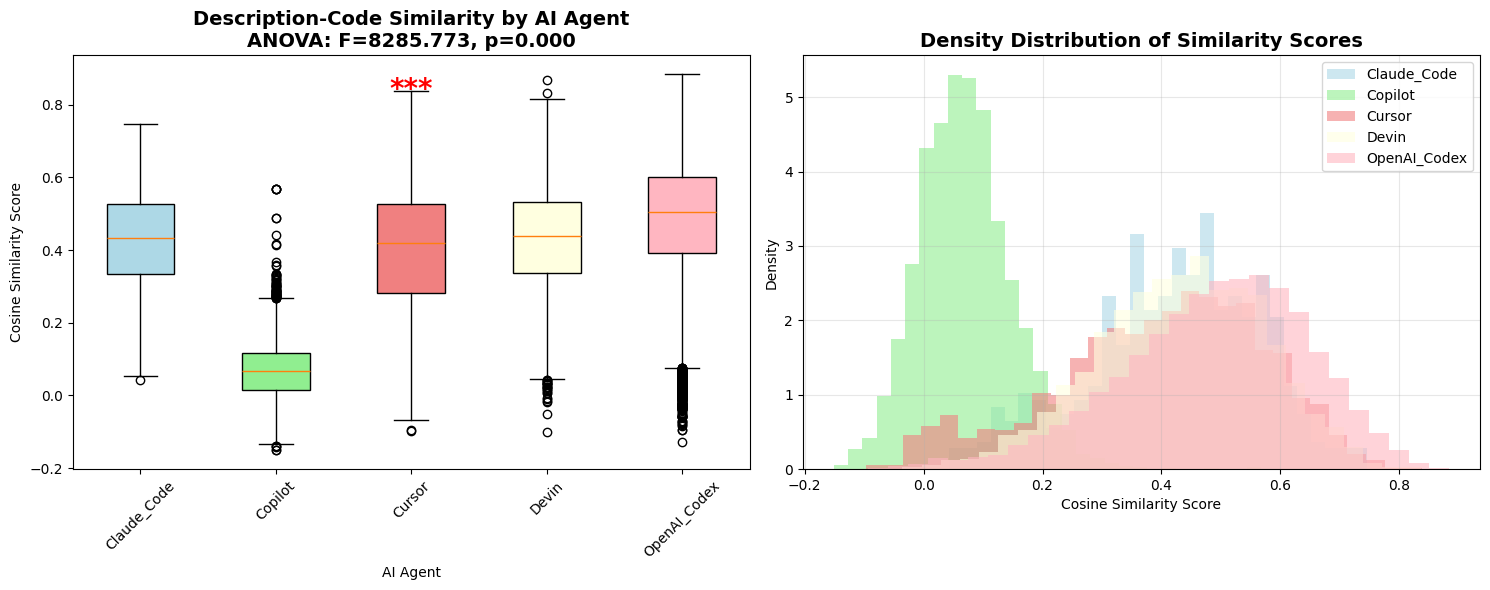

In [29]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

agents_to_plot = []
similarity_data = []

for agent, group in similarity_df.groupby('agent'):
    if len(group) > 50:
        agents_to_plot.append(agent)
        similarity_data.append(group['description_similarity'].values)

box_plot = axes[0].boxplot(similarity_data, labels=agents_to_plot, patch_artist=True)
axes[0].set_title(f'Description-Code Similarity by AI Agent\nANOVA: F={f_stat:.3f}, p={p_value:.3f}',
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Cosine Similarity Score')
axes[0].set_xlabel('AI Agent')
axes[0].tick_params(axis='x', rotation=45)

colors = ['lightblue', 'lightgreen', 'lightcoral', 'lightyellow', 'lightpink']
for patch, color in zip(box_plot['boxes'], colors[:len(agents_to_plot)]):
    patch.set_facecolor(color)

if p_value < 0.001:
    sig_text = '***'
elif p_value < 0.01:
    sig_text = '**'
elif p_value < 0.05:
    sig_text = '*'
else:
    sig_text = 'ns'

axes[0].text(0.5, 0.95, sig_text, transform=axes[0].transAxes,
            fontsize=20, fontweight='bold', color='red',
            ha='center', va='top')

for i, (agent, data) in enumerate(zip(agents_to_plot, similarity_data)):
    axes[1].hist(data, bins=30, alpha=0.6, label=agent, density=True,
                color=colors[i % len(colors)])

axes[1].set_title('Density Distribution of Similarity Scores', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Cosine Similarity Score')
axes[1].set_ylabel('Density')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('anova_similarity_results.png', dpi=300, bbox_inches='tight')
plt.show()

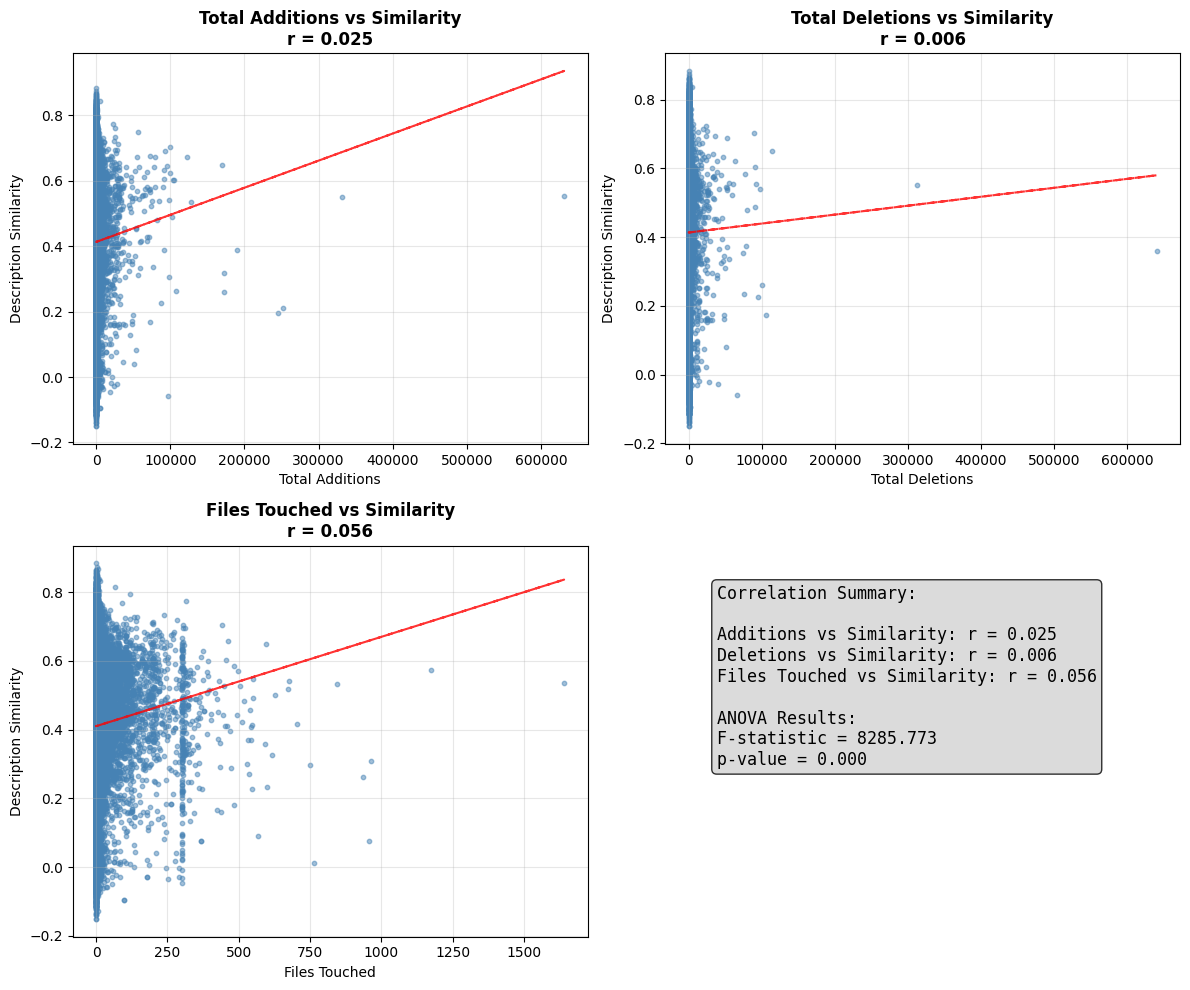

In [36]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.ravel()

metrics = ['total_additions', 'total_deletions', 'files_touched']
titles = ['Total Additions', 'Total Deletions', 'Files Touched']

for i, metric in enumerate(metrics):
    corr = correlation_matrix.loc[metric, 'description_similarity']

    axes[i].scatter(similarity_df[metric], similarity_df['description_similarity'],
                   alpha=0.5, s=10, color='steelblue')
    axes[i].set_xlabel(titles[i])
    axes[i].set_ylabel('Description Similarity')
    axes[i].set_title(f'{titles[i]} vs Similarity\nr = {corr:.3f}', fontweight='bold')
    axes[i].grid(True, alpha=0.3)

    z = np.polyfit(similarity_df[metric], similarity_df['description_similarity'], 1)
    p = np.poly1d(z)
    axes[i].plot(similarity_df[metric], p(similarity_df[metric]), "r--", alpha=0.8)

axes[3].axis('off')
summary_text = (
    "Correlation Summary:\n\n"
    f"Additions vs Similarity: r = {correlation_matrix.loc['total_additions', 'description_similarity']:.3f}\n"
    f"Deletions vs Similarity: r = {correlation_matrix.loc['total_deletions', 'description_similarity']:.3f}\n"
    f"Files Touched vs Similarity: r = {correlation_matrix.loc['files_touched', 'description_similarity']:.3f}\n\n"
    f"ANOVA Results:\n"
    f"F-statistic = {f_stat:.3f}\n"
    f"p-value = {p_value:.3f}"
)

axes[3].text(0.1, 0.9, summary_text, transform=axes[3].transAxes,
            fontsize=12, fontfamily='monospace', verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))

plt.tight_layout()
plt.savefig('correlation_scatter_plots.png', dpi=300, bbox_inches='tight')
plt.show()